# ECON622: Problem Set 3

Jesse Perla, UBC

## Student Name/Number: (doubleclick to edit)

# Packages

Add whatever packages you wish here

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from jax import grad, jvp, vjp
from jax import random
from numpy.linalg import cond

## Question 1: Conditioning and Preconditioned Gradient Descent

In this question, you will explore how the condition number affects
gradient descent convergence and implement a simple diagonal
preconditioner to improve performance.

We consider minimizing the quadratic function:

$$
f(x) = \frac{1}{2} x^\top P x
$$

where $P$ is a symmetric positive definite matrix. The gradient is
$\nabla f(x) = P x$, so the minimum is at $x^* = 0$.

### Starter Code

The following function visualizes gradient descent on a 2D quadratic:

In [2]:
def plot_gd_steps(N_steps, x_0, Lambda, eta, theta=np.pi/6):
    """
    Plot gradient descent steps on a 2D quadratic f(x) = 0.5 * x^T P x
    where P = Q @ diag(Lambda) @ Q^T for rotation angle theta.

    Args:
        N_steps: Number of GD iterations to plot
        x_0: Initial point [x1, x2]
        Lambda: Eigenvalues [lambda1, lambda2] (condition number = max/min)
        eta: Step size (learning rate)
        theta: Rotation angle for Q (default: pi/6)
    """
    c, s = np.cos(theta), np.sin(theta)
    Q = np.array([[c, -s], [s, c]])
    P = Q @ np.diag(Lambda) @ Q.T
    gd_step = lambda x: x - eta * P @ x

    x_vals = np.linspace(-1, 1, 100)
    X1, X2 = np.meshgrid(x_vals, x_vals)
    Z = 0.5 * (P[0,0]*X1**2 + 2*P[0,1]*X1*X2 + P[1,1]*X2**2)

    plt.figure(figsize=(6, 5))
    plt.contour(X1, X2, Z, levels=20, cmap='viridis')

    x_current = np.array(x_0)
    for i in range(N_steps):
        x_next = gd_step(x_current)
        plt.arrow(x_current[0], x_current[1],
                  x_next[0] - x_current[0], x_next[1] - x_current[1],
                  head_width=0.03, head_length=0.02, fc='red', ec='red')
        x_current = x_next

    plt.xlabel('x1'); plt.ylabel('x2')
    plt.gca().set_aspect('equal')
    return plt.gcf()

### Question 1.1: Explore Conditioning Visually

Run the visualization with different condition numbers and observe how
the contours change shape.

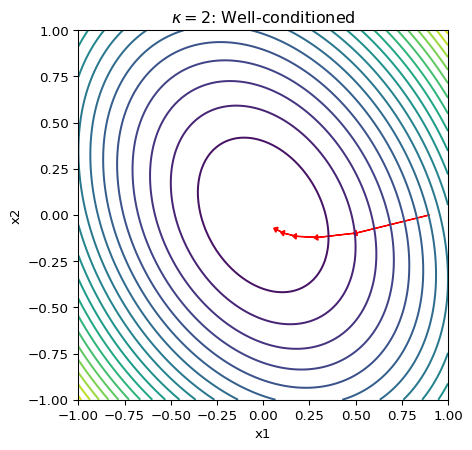

In [3]:
x_0 = [0.9, 0.0]
eta = 0.5

# Well-conditioned: kappa = 2
Lambda_good = np.array([1.0, 0.5])
plot_gd_steps(5, x_0, Lambda_good, eta)
plt.title(r'$\kappa = 2$: Well-conditioned')
plt.show()

Now run with $\kappa = 10$ (eigenvalues \[1.0, 0.1\]) and $\kappa = 100$
(eigenvalues \[1.0, 0.01\]).

In [4]:
# modify here

**(double click to edit your answer)**

Explain in 2-3 sentences why gradient descent struggles with
poorly-conditioned problems (narrow ellipses).

### Question 1.2: Count Iterations to Convergence

Use the following function to count how many iterations GD needs to
converge:

In [6]:
def count_gd_iterations(x_0, P, eta, tol=1e-6, max_iter=5000):
    """Count iterations until ||x|| < tol"""
    x = np.array(x_0)
    for i in range(max_iter):
        if np.linalg.norm(x) < tol:
            return i
        x = x - eta * P @ x
    return max_iter  # didn't converge

Helper function to create $P$ from eigenvalues:

In [7]:
def make_P(Lambda, theta=np.pi/6):
    """Create P = Q @ diag(Lambda) @ Q^T with rotation angle theta"""
    c, s = np.cos(theta), np.sin(theta)
    Q = np.array([[c, -s], [s, c]])
    return Q @ np.diag(Lambda) @ Q.T

Count iterations for $\kappa = 2, 10, 100$ with `eta = 0.5` and
`x_0 = [0.9, 0.0]`:

In [8]:
# modify here

**(double click to edit your answer)**

Report the iteration counts and explain the relationship between
$\kappa$ and convergence rate.

### Question 1.3 (BONUS): Understand Preconditioned Gradient Descent

Standard gradient descent updates:

$$
x^{k+1} = x^k - \eta \nabla f(x^k) = x^k - \eta P x^k
$$

**Preconditioned gradient descent** scales the gradient by a matrix
$D^{-1}$:

$$
x^{k+1} = x^k - \eta D^{-1} \nabla f(x^k) = x^k - \eta D^{-1} P x^k
$$

**Your task:** Show that preconditioned GD is equivalent to standard GD
on a transformed problem.

Let $\tilde{x} = D^{1/2} x$ (assuming $D$ is diagonal with positive
entries). Show that:

1.  The objective becomes
    $\tilde{f}(\tilde{x}) = \frac{1}{2} \tilde{x}^\top \tilde{P} \tilde{x}$
    where $\tilde{P} = D^{-1/2} P D^{-1/2}$
2.  If we choose $D = \text{diag}(P)$, what are the diagonal entries of
    $\tilde{P}$?

**(double click to edit your answer)**

Derivation:

### Question 1.4: Implement Diagonal Preconditioning

Implement preconditioned GD and compare iteration counts:

In [10]:
def count_preconditioned_gd_iterations(x_0, P, D_inv, eta, tol=1e-6, max_iter=5000):
    """Count iterations for preconditioned GD: x_{k+1} = x_k - eta * D^{-1} @ P @ x_k"""
    x = np.array(x_0)
    for i in range(max_iter):
        if np.linalg.norm(x) < tol:
            return i
        # modify here: implement preconditioned step
        x = x - eta * P @ x
    return max_iter

Test with $\kappa = 100$:

In [11]:
Lambda = np.array([1.0, 0.01])
P = make_P(Lambda)
D_inv = np.diag(1.0 / np.diag(P))  # D^{-1} where D = diag(P)

# modify here: compare iterations with and without preconditioning

### Question 1.5: Verify the Condition Number Improvement

Compute and compare the condition numbers before and after
preconditioning:

In [13]:
Lambda = np.array([1.0, 0.01])
P = make_P(Lambda)
D = np.diag(np.diag(P))
D_sqrt_inv = np.diag(1.0 / np.sqrt(np.diag(P)))

# Preconditioned matrix: D^{-1/2} P D^{-1/2}
P_precond = D_sqrt_inv @ P @ D_sqrt_inv

# modify here: compute and print condition numbers
print(f"cond(P) = ...")
print(f"cond(P_precond) = ...")

cond(P) = ...
cond(P_precond) = ...

**(double click to edit your answer)**

Explain why the diagonal preconditioner improves the condition number
for this problem.

### Question 1.6: When Diagonal Preconditioning Fails

The effectiveness of diagonal preconditioning depends on the rotation
angle $\theta$ used to construct $P = Q(\theta) \Lambda Q(\theta)^\top$.

Repeat the preconditioning experiment from Q1.4-1.5 with
$\theta = \pi/4$ (a 45-degree rotation). Compare iteration counts with
and without preconditioning, and compute the condition numbers of $P$
and $\tilde{P}$.

In [15]:
Lambda = np.array([1.0, 0.01])

# modify here: construct P with theta = pi/4, compute D_inv, and compare
# iterations with and without preconditioning
# Also compute cond(P) and cond(P_precond)

**(double click to edit your answer)**

1.  What do you observe about the iteration counts?
2.  Examine the diagonal entries of $P$ at $\theta = \pi/4$. Why does
    diagonal preconditioning fail here?
3.  What is $D^{-1}$ in this case, and what does the preconditioned step
    $x - \eta D^{-1} P x$ simplify to?

## Question 2: Vectorized AD Rule for Matrix-Vector Product

In this question, you will derive the JVP and VJP rules for a vectorized
operation (matrix-vector multiplication) and verify your implementation
against JAX.

Consider the function $f(A, x) = Ax$ where
$A \in \mathbb{R}^{m \times n}$ and $x \in \mathbb{R}^n$.

### Question 2.1: Derive the JVP Rule

Given tangents $\dot{A} \in \mathbb{R}^{m \times n}$ and
$\dot{x} \in \mathbb{R}^n$, derive the pushforward (JVP):

$$
\dot{y} = \partial f(A, x)[(\dot{A}, \dot{x})] = ?
$$

**Hint:** Use the product rule for differentiation.

**(double click to edit your answer)**

Derivation:

### Question 2.2 (BONUS): Derive the VJP Rule

Given a cotangent $\bar{y} \in \mathbb{R}^m$, derive the pullback (VJP):

$$
(\bar{A}, \bar{x}) = \partial f(A, x)^\top[\bar{y}] = ?
$$

**Hint for adjoint algebra:** Start with the inner product
$\langle \bar{y}, \dot{y} \rangle = \langle \bar{y}, \dot{A} x + A \dot{x} \rangle$
and rearrange to identify $\bar{A}$ and $\bar{x}$.

Recall that for matrices, $\langle U, V \rangle = \text{Tr}(U^\top V)$,
and for vectors, $\langle u, v \rangle = u^\top v$.

**(double click to edit your answer)**

Derivation:

### Question 2.3: Implement and Verify JVP

Implement your JVP rule and verify against JAX:

In [17]:
def matvec(A, x):
    """f(A, x) = A @ x"""
    return A @ x

def matvec_jvp(A, x, A_dot, x_dot):
    """Your implementation of the JVP rule: returns y_dot"""
    # modify here
    pass

# Test data
key = random.PRNGKey(42)
keys = random.split(key, 4)
m, n = 4, 3
A = random.normal(keys[0], (m, n))
x = random.normal(keys[1], (n,))
A_dot = random.normal(keys[2], (m, n))
x_dot = random.normal(keys[3], (n,))

# modify here: compare to JAX jvp

### Question 2.4: Implement and Verify VJP

Implement your VJP rule and verify against JAX:

In [19]:
def matvec_vjp(A, x, y_bar):
    """Your implementation of the VJP rule: returns (A_bar, x_bar)"""
    # modify here
    pass

# Test cotangent
y_bar = random.normal(random.PRNGKey(99), (m,))

# modify here: compare to JAX vjp

**(double click to edit your answer)**

Explain in 2-3 sentences the connection between the VJP formula
$\bar{x} = A^\top \bar{y}$ and the “adjoint” or “transpose” terminology
used in automatic differentiation.

## Question 3 (BONUS): Sensitivity Analysis via the LLS Adjoint

In this question, you will derive and apply the VJP (adjoint) rule for
linear least squares to perform sensitivity analysis: understanding how
each observation affects the estimated coefficients.

### The Linear Least Squares Problem

Given design matrix $X \in \mathbb{R}^{n \times p}$ and observations
$y \in \mathbb{R}^n$, the least squares solution is:

$$
\hat{\beta} = (X^\top X)^{-1} X^\top y
$$

### Question 3.1: The LLS Adjoint Rule

The VJP rule for $\hat{\beta} = \text{LLS}(X, y)$ is derived by chaining
through the matrix inverse and products.

**Given:** A cotangent $\bar{\beta} \in \mathbb{R}^p$ (representing “how
much we care about each coefficient”)

**Compute:**

1.  Solve the linear system: $g = (X^\top X)^{-1} \bar{\beta}$
2.  Compute the residual: $r = y - X\hat{\beta}$

**Then the adjoints are:**

$$
\bar{y} = X g
$$

$$
\bar{X} = r\, g^\top - (Xg)\, \hat{\beta}^\top
$$

**(double click to edit your answer)**

Explain in 2-3 sentences why this is computationally powerful: if we
want to know how $\hat{\beta}_0$ depends on ALL $n$ observations $y_i$,
how many backward passes do we need?

### Question 3.2: Generate Data and Compute LLS

In [21]:
# Generate random regression data
key = random.PRNGKey(123)
keys = random.split(key, 3)

n = 1000  # observations
p = 3     # parameters

# True coefficients
beta_true = jnp.array([2.0, -1.0, 0.5])

# Random design matrix and noisy observations
X = random.normal(keys[0], (n, p))
noise = 0.1 * random.normal(keys[1], (n,))
y = X @ beta_true + noise

# Compute LLS solution
beta_hat = jnp.linalg.lstsq(X, y)[0]
print(f"True beta: {beta_true}")
print(f"Estimated beta: {beta_hat}")

True beta: [ 2.  -1.   0.5]
Estimated beta: [ 2.0004642  -1.0009896   0.49019286]

### Question 3.3: Manual Sensitivity Calculation

Use the LLS adjoint rule to compute
$\partial \hat{\beta}_0 / \partial y_i$ for all observations.

In [22]:
# We want sensitivity of beta_hat[0] to each y_i
# Set beta_bar = e_0 = [1, 0, 0]
beta_bar = jnp.array([1.0, 0.0, 0.0])

# modify here: compute g, r, and y_bar using the adjoint formula
# g = (X^T X)^{-1} @ beta_bar
# r = y - X @ beta_hat
# y_bar = X @ g

### Question 3.4: Verify with JAX VJP

Use JAX’s built-in autodiff to verify your manual calculation:

In [24]:
def lls(y):
    """LLS as a function of y only (X is fixed)"""
    return jnp.linalg.lstsq(X, y)[0]

# modify here: use vjp to compute sensitivity of beta_hat[0] to y
# beta_hat_jax, vjp_fun = vjp(lls, y)
# y_bar_jax, = vjp_fun(beta_bar)
# Compare to y_bar_manual

### Question 3.5: Interpret the Sensitivities

Plot the sensitivities and identify influential observations:

In [26]:
# modify here: create a plot showing the sensitivities
# plt.figure(figsize=(10, 4))
# plt.plot(y_bar_manual, 'o', alpha=0.5, markersize=3)
# plt.xlabel('Observation index i')
# plt.ylabel(r'$\partial \hat{\beta}_0 / \partial y_i$')
# plt.title('Sensitivity of $\\hat{\\beta}_0$ to each observation')
# plt.show()

# Find the most influential observations
# top_indices = jnp.argsort(jnp.abs(y_bar_manual))[-5:]

**(double click to edit your answer)**

1.  What determines whether an observation has high sensitivity (large
    $|\partial \hat{\beta}_0 / \partial y_i|$)?
2.  How does this relate to the concept of “leverage” in regression
    diagnostics?

### Question 3.6 (Extra Credit): Sensitivity to X

The full adjoint rule also gives $\bar{X}$. Compute and interpret the
sensitivity of $\hat{\beta}_0$ to changes in $X_{ij}$.

In [28]:
# modify here: compute X_bar using the full adjoint formula
# X_bar = r @ g.T - (X @ g) @ beta_hat.T
# This gives d(beta_hat[0])/d(X_ij) for all i,j

**(double click to edit your answer)**

What is the computational advantage of using the adjoint/VJP approach
for this sensitivity analysis compared to finite differences?